3. Player Movement Between Clubs:

Objective: Visualize the movement of players between clubs geographically over different seasons.

Data: Use df_players for player details, df_club for club information, and df_app for appearance data.

GeoPandas Usage: Create GeoDataFrames for clubs based on their locations. Plot the transfer movements of players from one club to another over time to show migration patterns.

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import string
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.geocoders import OpenCage
from shapely.geometry import Point
from opencage.geocoder import OpenCageGeocode
import time
plt.style.use('ggplot')

In [293]:


df_players = pd.read_csv('AssignmentData/players.csv')
df_club = pd.read_csv('AssignmentData/clubs.csv')
df_app = pd.read_csv('AssignmentData/appearances.csv')

df_club_games = pd.read_csv('AssignmentData/club_games.csv')
df_comp = pd.read_csv('AssignmentData/competitions.csv')
df_game_events = pd.read_csv('AssignmentData/game_events.csv')
df_game_lineups = pd.read_csv('AssignmentData/game_lineups.csv')
df_games = pd.read_csv('AssignmentData/games.csv')
df_player_val = pd.read_csv('AssignmentData/player_valuations.csv')
pd.set_option('display.max_columns', None) # Display all columns

### Data Cleaning

In [294]:
df_players.columns

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'market_value_in_eur',
       'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name'],
      dtype='object')

In [295]:
df_players = df_players[
['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position', 'market_value_in_eur',
       'highest_market_value_in_eur', 'contract_expiration_date',
       'current_club_domestic_competition_id',
       'current_club_name']
]

In [296]:
df_club.columns

Index(['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'stadium_seats', 'net_transfer_record', 'coach_name', 'last_season',
       'url'],
      dtype='object')

In [297]:
df_club = df_club[
['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'net_transfer_record', 'last_season']
]

In [298]:
df_app

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507346,4172154_659813,4172154,659813,15,15,2023-11-30,Piero Hincapié,EL,0,0,0,0,90
1507347,4172154_696027,4172154,696027,15,15,2023-11-30,Ayman Aourir,EL,0,0,0,0,2
1507348,4172154_7161,4172154,7161,15,15,2023-11-30,Jonas Hofmann,EL,0,0,0,0,10
1507349,4172154_743395,4172154,743395,15,15,2023-11-30,Noah Mbamba,EL,0,0,0,0,45


### Geocode Club Locations
If the coordinates are not available, geocode the stadium names.

In [299]:

# Initialize geolocator with your OpenCage API key
geolocator = OpenCage(api_key='95b5a6ef1e2a464ab87007187ae53dbe')

# Function to get latitude and longitude
def geocode_stadium(stadium_name):
    try:
        location = geolocator.geocode(stadium_name)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Apply geocoding to the stadium names if coordinates are not available
if 'latitude' not in df_club.columns or 'longitude' not in df_club.columns:
    df_club['latitude'], df_club['longitude'] = zip(*df_club['stadium_name'].apply(lambda x: geocode_stadium(x) if pd.notnull(x) else (None, None)))
    # Add a delay between requests to avoid hitting rate limits
    # time.sleep(1)

# Drop rows with missing coordinates
df_club.dropna(subset=['latitude', 'longitude'], inplace=True)


### Create GeoDataFrames

In [276]:
# Create GeoDataFrame for clubs
gdf_club = gpd.GeoDataFrame(df_club, geometry=gpd.points_from_xy(df_club.longitude, df_club.latitude))

# Merge player data with club data for current and previous clubs
df_player_movements = df_app[['player_id', 'player_club_id', 'player_current_club_id']].drop_duplicates()

# Merge to get current and previous club locations
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_club_id', right_on='club_id', suffixes=('_prev', '_curr'))
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_current_club_id', right_on='club_id', suffixes=('_prev', '_curr'))

# Filter out movements with missing coordinates
df_player_movements.dropna(subset=['latitude_prev', 'longitude_prev', 'latitude_curr', 'longitude_curr'], inplace=True)

### Generate and Visualize all Club (Global View) 

In [281]:
# Function to reverse geocode coordinates to location names
geocoder = OpenCageGeocode('95b5a6ef1e2a464ab87007187ae53dbe')

def reverse_geocode(lat, lng):
    result = geocoder.reverse_geocode(lat, lng)
    if result and len(result):
        return result[0]['components']['country']
    return None

# Convert latitude and longitude to location names using OpenCage
gdf_club['club_location'] = gdf_club.apply(lambda row: reverse_geocode(row['latitude'], row['longitude']), axis=1)


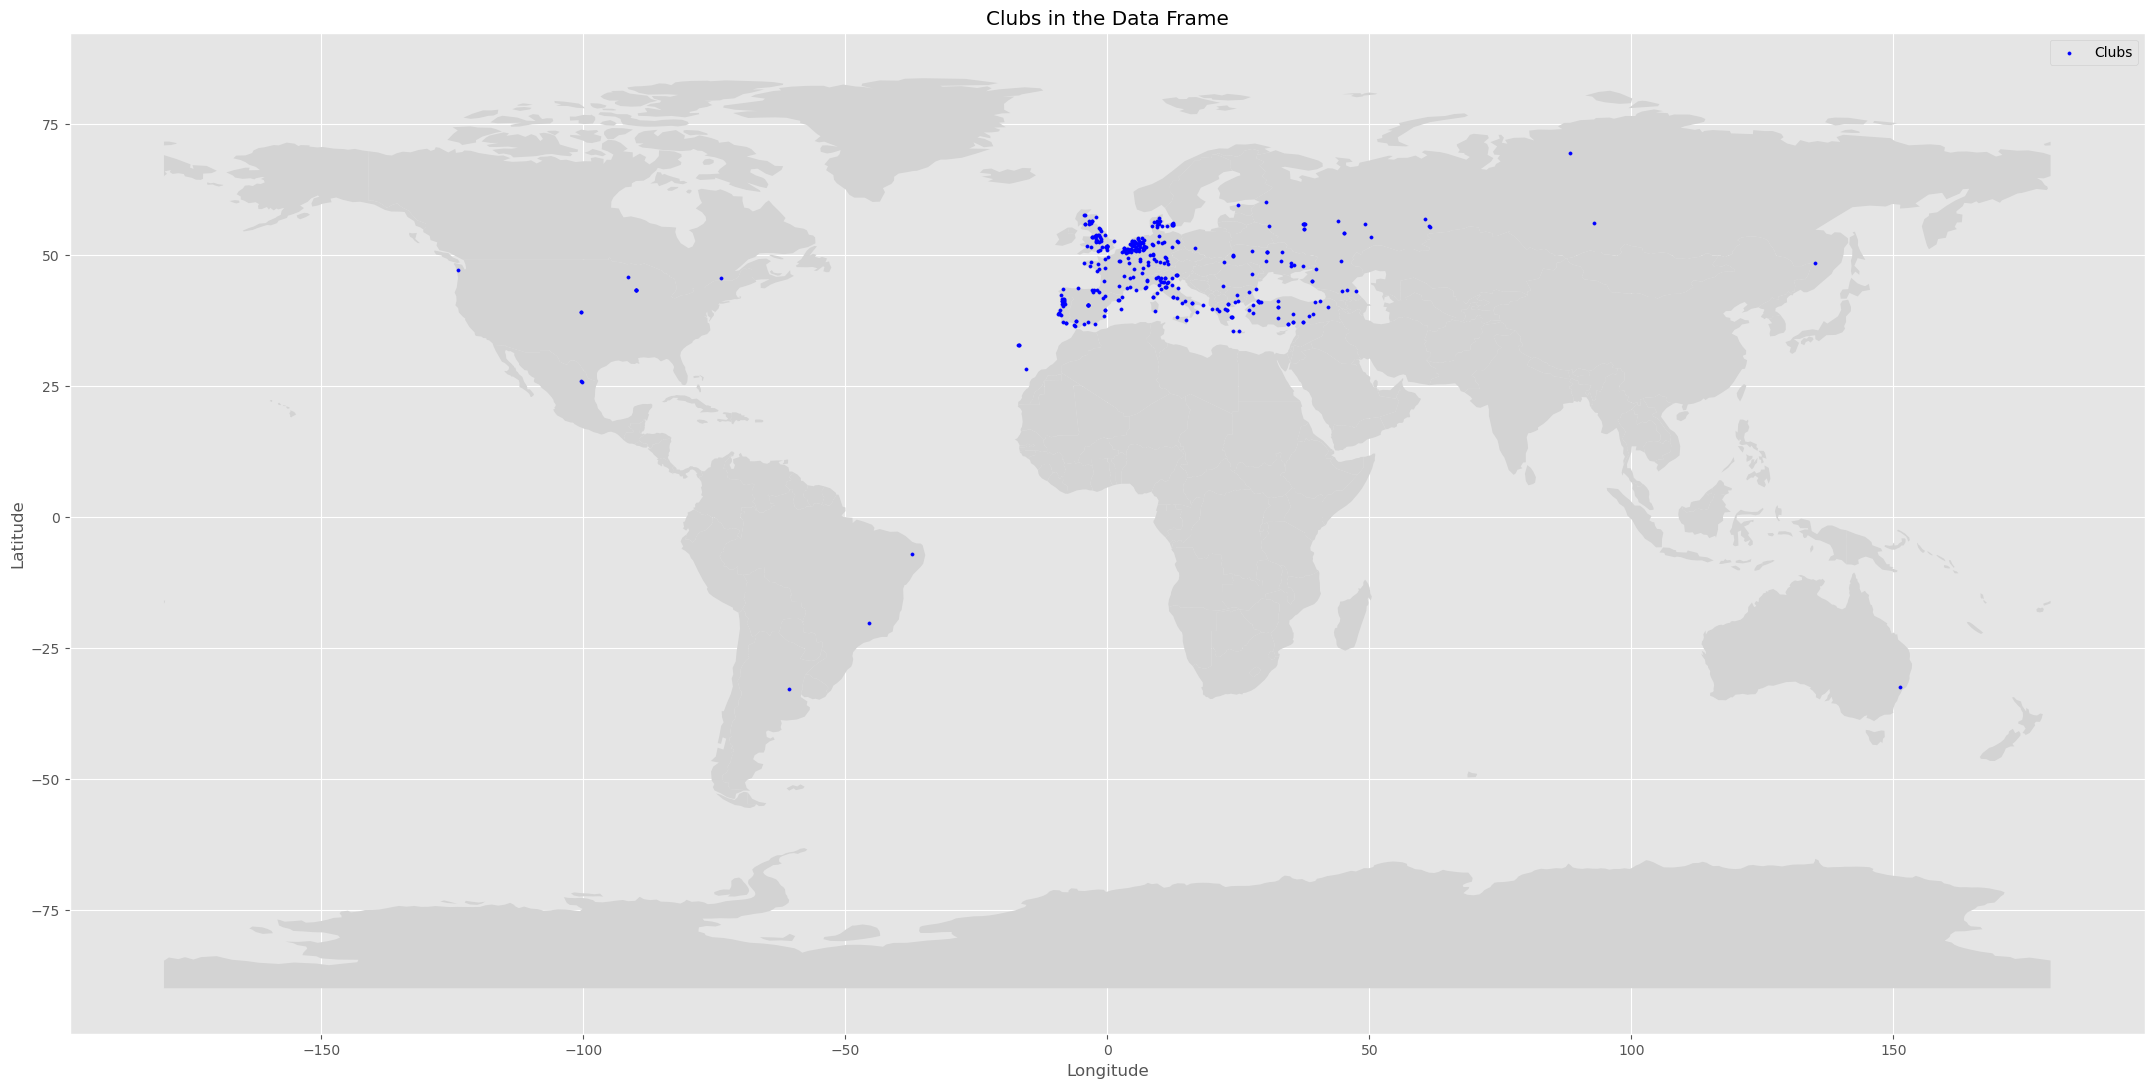

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,net_transfer_record,last_season,latitude,longitude,geometry,club_location
0,105,sv-darmstadt-98,Sportverein Darmstadt 1898 e. V.,L1,NaN,30,26.4,11,36.7,1,Merck-Stadion am Böllenfalltor,€-1.60m,2023,49.857710,8.672415,POINT (8.67241 49.85771),Germany
1,11127,ural-ekaterinburg,FK Ural Yekaterinburg,RU1,NaN,25,28.2,13,52.0,5,Yekaterinburg Arena,€-770k,2023,56.837757,60.653692,POINT (60.65369 56.83776),Russia
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,NaN,32,27.4,16,50.0,13,Tüpraş Stadyumu,€-14.50m,2023,41.039444,28.994412,POINT (28.99441 41.03944),Turkey
3,12,as-rom,Associazione Sportiva Roma,IT1,NaN,26,27.4,17,65.4,17,Olimpico di Roma,+€65.20m,2023,41.933942,12.454771,POINT (12.45477 41.93394),Italy
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,NaN,29,26.2,21,72.4,22,Tottenham Hotspur Stadium,€-130.40m,2023,51.604157,-0.066260,POINT (-0.06626 51.60416),United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,607,venezia-fc,Venezia FC,IT1,NaN,27,25.6,17,63.0,5,Pier Luigi Penzo,+€4.83m,2021,45.429691,12.355676,POINT (12.35568 45.42969),Italy
421,68608,cf-os-belenenses,CF Os Belenenses,PO1,NaN,30,25.7,5,16.7,0,Estádio do Restelo,+-0,2017,38.702582,-9.207933,POINT (-9.20793 38.70258),Portugal
422,724,fc-volendam,Football Club Volendam,NL1,NaN,29,22.8,14,48.3,3,Kras Stadion,+€1.80m,2023,52.494383,5.066279,POINT (5.06628 52.49438),Netherlands
423,800,atalanta-bergamo,Atalanta Bergamasca Calcio S.p.a.,IT1,NaN,25,27.2,17,68.0,15,Gewiss Stadium,+€87.00m,2023,45.709207,9.680833,POINT (9.68083 45.70921),Italy


In [285]:
# Create GeoDataFrame for player movements
# gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Load the world map from the downloaded shapefile
world = gpd.read_file('geopandas_shapefile/ne_110m_admin_0_countries.shp')

fig, ax = plt.subplots(figsize=(29, 13))
world.plot(ax=ax, color='lightgrey')

# Plot club locations
gdf_club.plot(ax=ax, color='blue', markersize=5, label='Clubs')


plt.title('Clubs in the Data Frame')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
gdf_club

### Generate and Visualize all Clubs (Europe View)

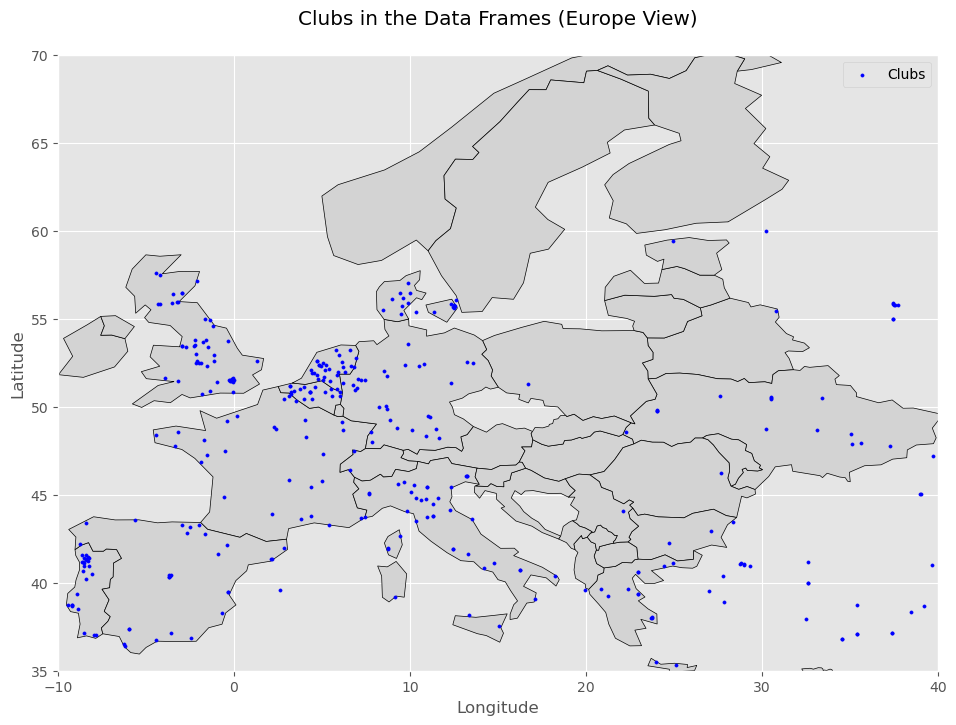

In [286]:
# Create GeoDataFrame for player movements
gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Plot the Europe map with player movements
fig, ax = plt.subplots(figsize=(12, 8))
europe_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot player movements as points
# gdf_prev.plot(ax=ax, color='red', markersize=50, label='Player Movements (Previous Club)')
# gdf_curr.plot(ax=ax, color='blue', markersize=50, label='Player Movements (Current Club)')
gdf_club.plot(ax=ax, color='blue', markersize=5, label='Clubs')

# Adjust plot limits to ensure all points are visible
ax.set_xlim([-10, 40])  # Example adjustment based on data extent
ax.set_ylim([35, 70])   # Example adjustment based on data extent

plt.title('Clubs in the Data Frames (Europe View)\n')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Generate and Visualize all Player Movements between clubs (Global View)

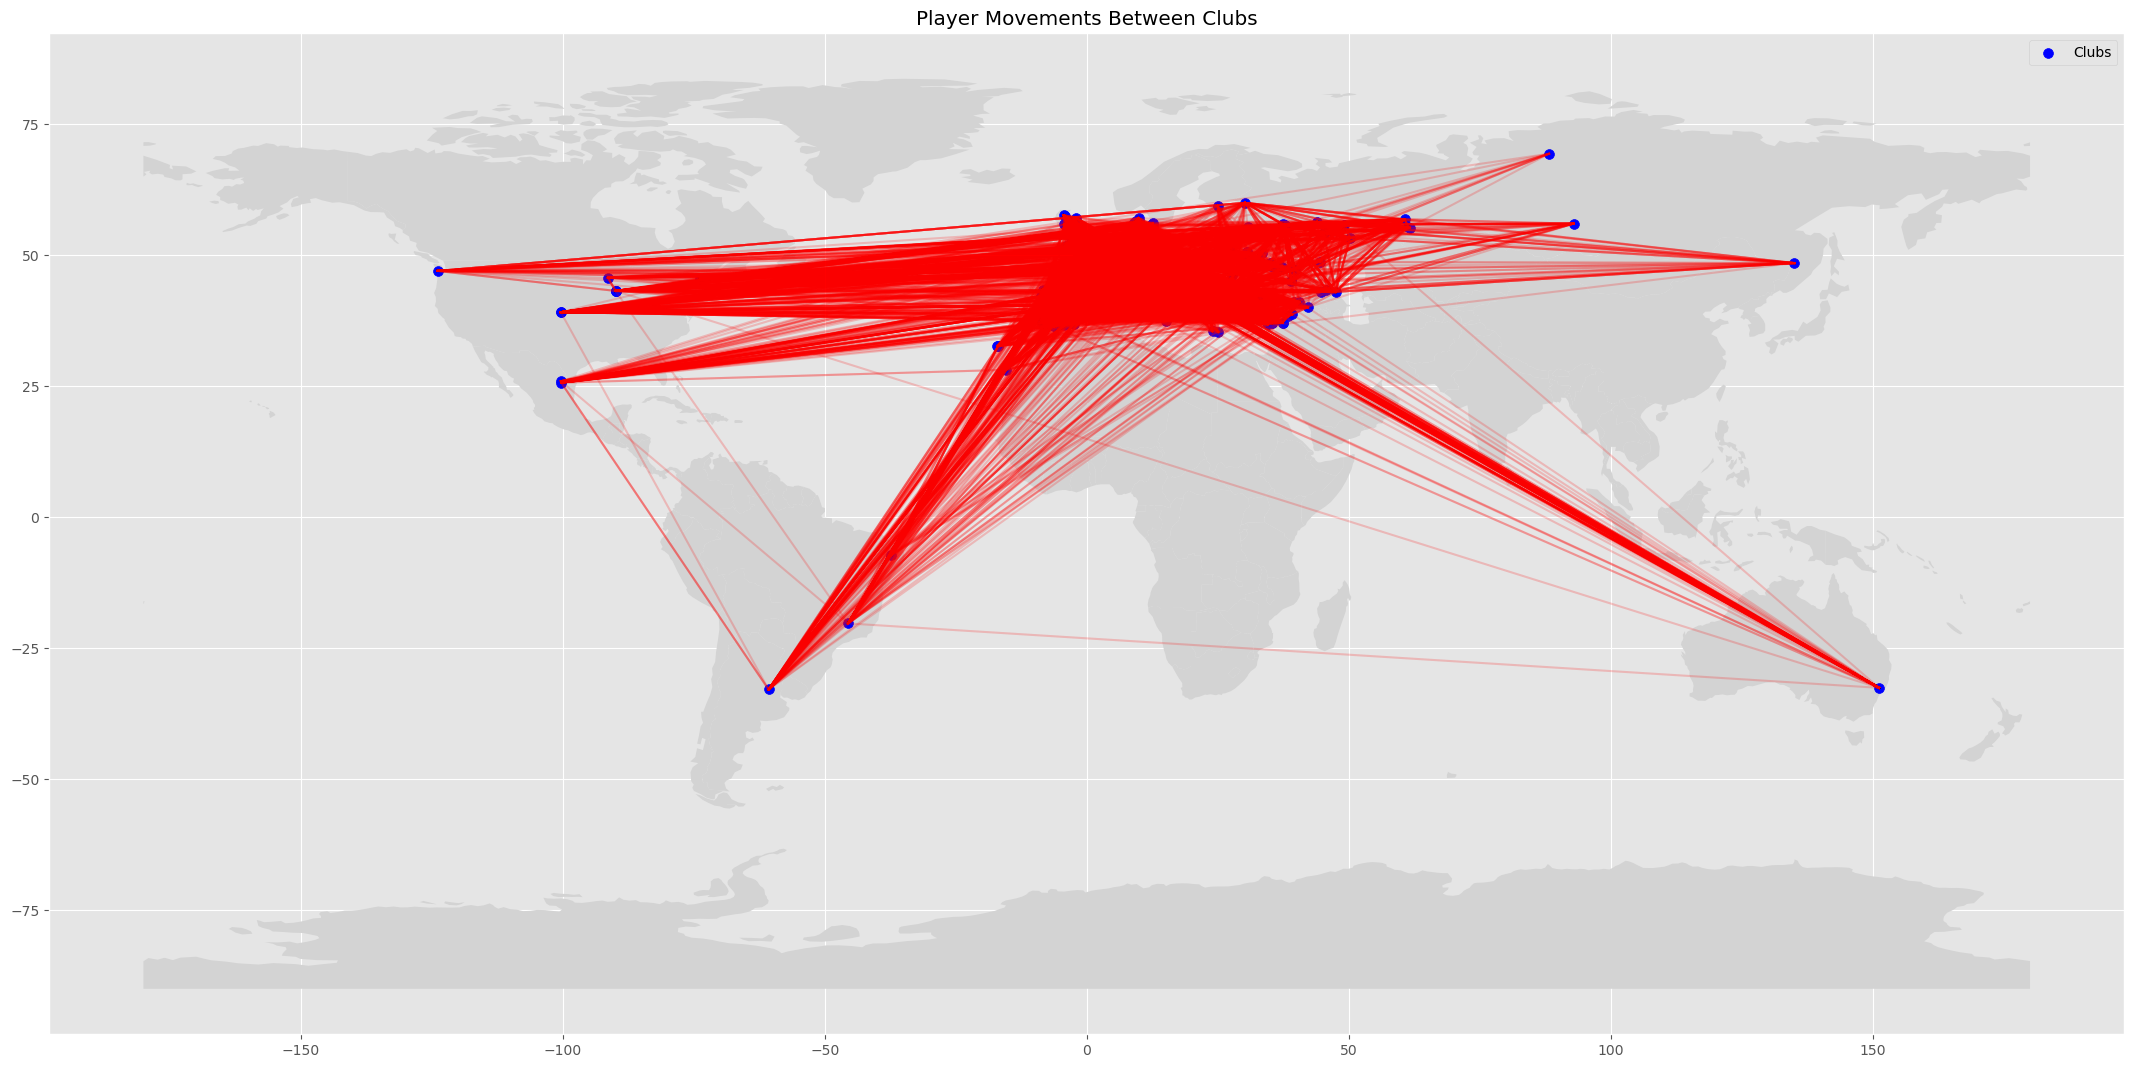

In [287]:
# Create GeoDataFrame for player movements
gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Load the world map from the downloaded shapefile
world = gpd.read_file('geopandas_shapefile/ne_110m_admin_0_countries.shp')

fig, ax = plt.subplots(figsize=(29, 13))
world.plot(ax=ax, color='lightgrey')

# Plot club locations
gdf_club.plot(ax=ax, color='blue', markersize=50, label='Clubs')

# Plot player movements as lines
for idx, row in df_player_movements.iterrows():
    plt.plot([row['longitude_prev'], row['longitude_curr']], [row['latitude_prev'], row['latitude_curr']], color='red', alpha=0.2)

plt.title('Player Movements Between Clubs')
plt.legend()
plt.show()

In [218]:
# # Create GeoDataFrame for clubs
# gdf_club = gpd.GeoDataFrame(df_club, geometry=gpd.points_from_xy(df_club.longitude, df_club.latitude))

# # Count the number of unique clubs each player has been associated with
# player_club_counts = df_app[['player_id', 'player_club_id']].drop_duplicates().groupby('player_id').count()

# # Merge with df_players to get player names
# player_club_counts = player_club_counts.merge(df_players[['player_id', 'name']], on='player_id')

# # Identify the player with the highest number of club movements
# player_with_max_movements = player_club_counts.loc[player_club_counts['player_club_id'].idxmin()]

# # Get player ID and name
# player_id_with_max_movements = player_with_max_movements['player_id']
# player_name_with_max_movements = player_with_max_movements['name']

# # Filter movements for this player
# df_player_movements = df_app[df_app['player_id'] == player_id_with_max_movements][['player_id', 'player_club_id', 'player_current_club_id']].drop_duplicates()

# # Merge to get current and previous club locations
# df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_club_id', right_on='club_id', suffixes=('_prev', '_curr'))
# df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_current_club_id', right_on='club_id', suffixes=('_prev', '_curr'))

# # Filter out movements with missing coordinates
# df_player_movements.dropna(subset=['latitude_prev', 'longitude_prev', 'latitude_curr', 'longitude_curr'], inplace=True)

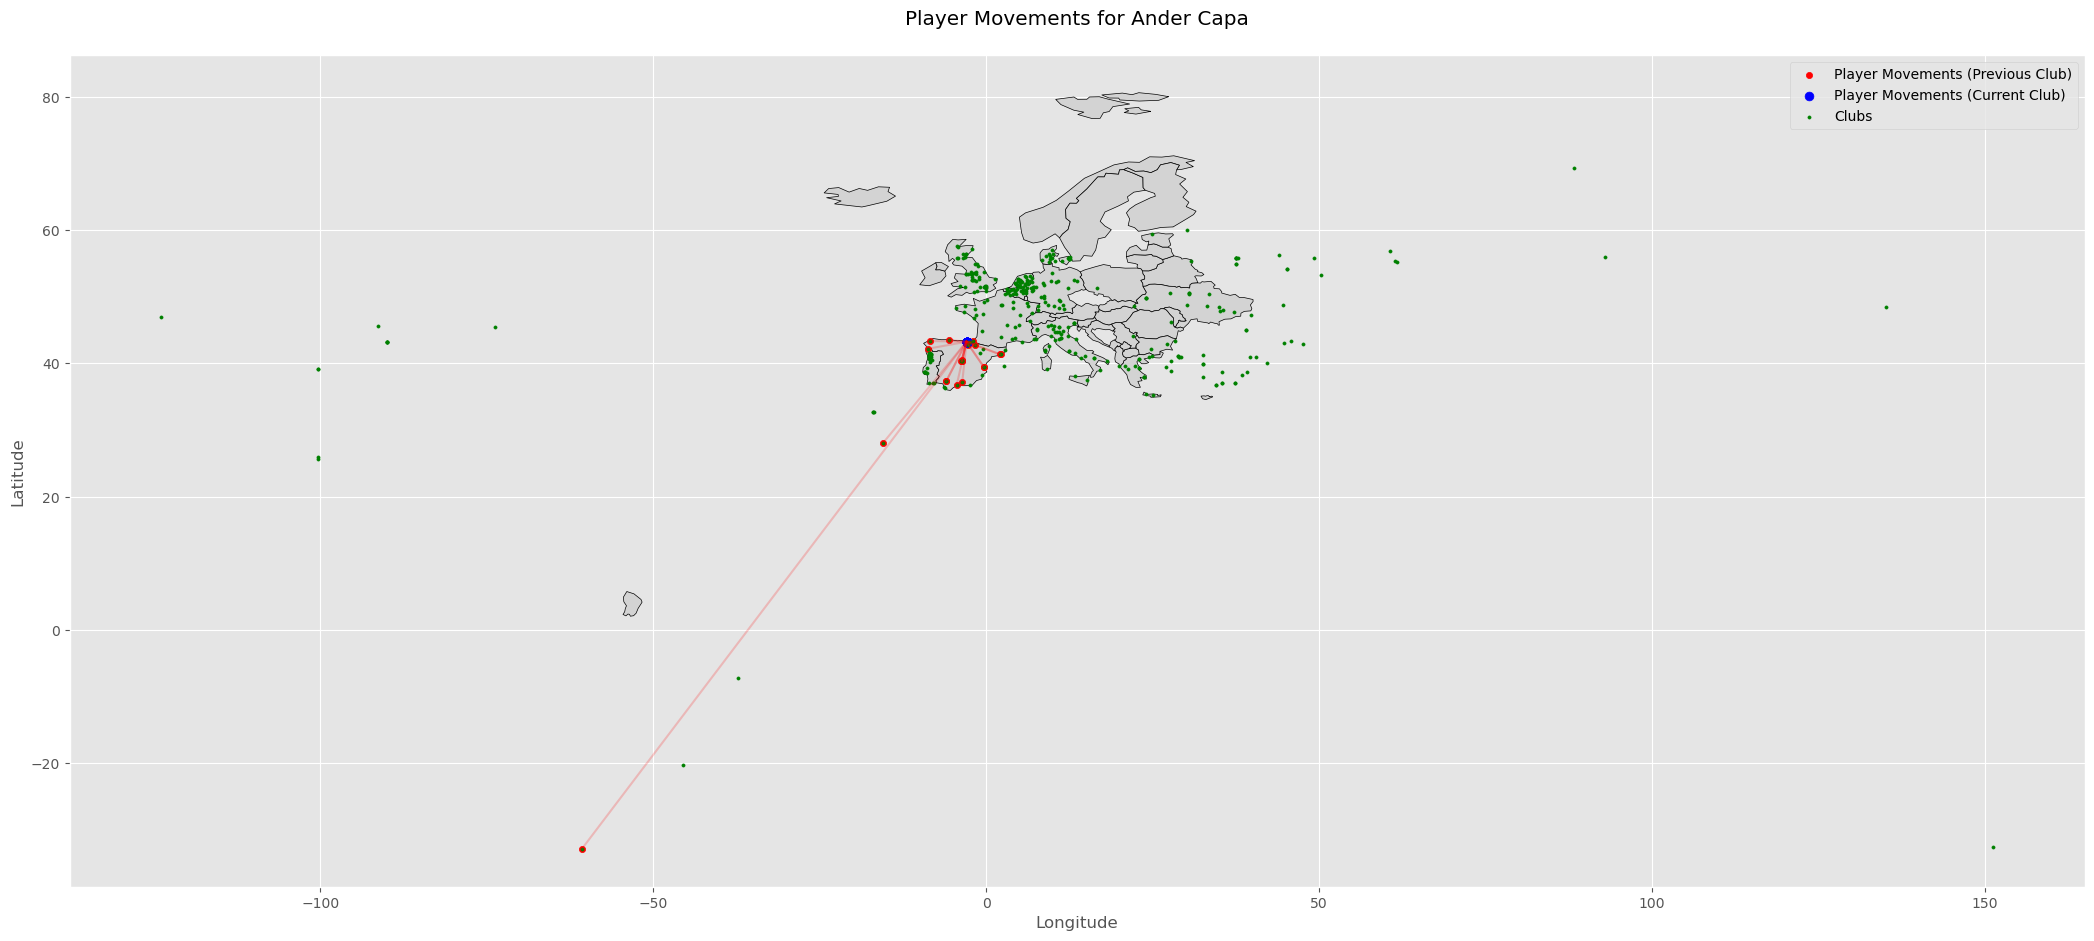

In [301]:
gdf_club = gpd.GeoDataFrame(df_club, geometry=gpd.points_from_xy(df_club.longitude, df_club.latitude))

# Count the number of unique clubs each player has been associated with
player_club_counts = df_app[['player_id', 'player_club_id']].drop_duplicates().groupby('player_id').count()

# Merge with df_players to get player names
player_club_counts = player_club_counts.merge(df_players[['player_id', 'name']], on='player_id')

# Identify the player with the highest number of club movements
player_with_max_movements = player_club_counts.loc[player_club_counts['player_club_id'].idxmax()]

# Get player ID and name
player_id_with_max_movements = player_with_max_movements['player_id']
player_name_with_max_movements = player_with_max_movements['name']

# Filter movements for this player
df_player_movements = df_app[df_app['player_id'] == player_id_with_max_movements][['player_id', 'player_club_id', 'player_current_club_id']].drop_duplicates()

# Merge to get current and previous club locations
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_club_id', right_on='club_id', suffixes=('_prev', '_curr'))
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_current_club_id', right_on='club_id', suffixes=('_prev', '_curr'))

# Filter out movements with missing coordinates
df_player_movements.dropna(subset=['latitude_prev', 'longitude_prev', 'latitude_curr', 'longitude_curr'], inplace=True)

# Create GeoDataFrame for player movements (only for the player with max movements)
geometry_prev = [Point(xy) for xy in zip(df_player_movements['longitude_prev'], df_player_movements['latitude_prev'])]
geometry_curr = [Point(xy) for xy in zip(df_player_movements['longitude_curr'], df_player_movements['latitude_curr'])]

gdf_prev = gpd.GeoDataFrame(df_player_movements, geometry=geometry_prev, crs='EPSG:4326')
gdf_curr = gpd.GeoDataFrame(df_player_movements, geometry=geometry_curr, crs='EPSG:4326')

# Load the world map from the downloaded shapefile
world = gpd.read_file('geopandas_shapefile/ne_110m_admin_0_countries.shp')

# List of European countries
europe = ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
          'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
          'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo',
          'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco',
          'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
          'Romania', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
          'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican City']

europe_map = world[world['NAME'].isin(europe)]


# Plot the Europe map with player movements
fig, ax = plt.subplots(figsize=(26, 25))  # Increase figsize as desired
europe_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot player movements as points
gdf_prev.plot(ax=ax, color='red', markersize=20, label='Player Movements (Previous Club)')
gdf_curr.plot(ax=ax, color='blue', markersize=40, label='Player Movements (Current Club)')

# Plot club locations
gdf_club.plot(ax=ax, color='green', markersize=5, label='Clubs')

# Plot player movements as lines
for idx, row in df_player_movements.iterrows():
    plt.plot([row['longitude_prev'], row['longitude_curr']], [row['latitude_prev'], row['latitude_curr']], color='red', alpha=0.2)

plt.title(f'Player Movements for {player_name_with_max_movements}\n')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

###  Load the Europe-specific shapefile

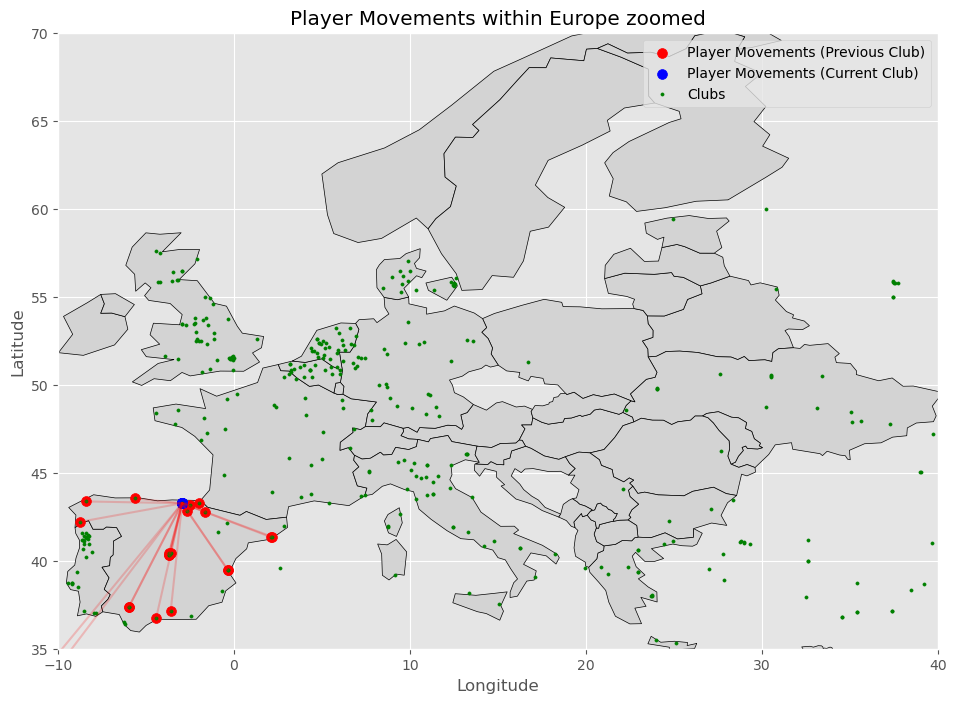

In [291]:
# Create GeoDataFrame for player movements
gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Plot the Europe map with player movements
fig, ax = plt.subplots(figsize=(12, 8))
europe_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot player movements as points
gdf_prev.plot(ax=ax, color='red', markersize=50, label='Player Movements (Previous Club)')
gdf_curr.plot(ax=ax, color='blue', markersize=50, label='Player Movements (Current Club)')
gdf_club.plot(ax=ax, color='green', markersize=5, label='Clubs')

# Plot player movements as lines
for idx, row in df_player_movements.iterrows():
    plt.plot([row['longitude_prev'], row['longitude_curr']], [row['latitude_prev'], row['latitude_curr']], color='red', alpha=0.2)
    
# Adjust plot limits to ensure all points are visible
ax.set_xlim([-10, 40])  # Example adjustment based on data extent
ax.set_ylim([35, 70])   # Example adjustment based on data extent

plt.title('Player Movements within Europe zoomed')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()